In [144]:
# import libraries needed
from pathlib import Path
import os, yaml, time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# load in data
file_name = '../../Data/box_111_DM_particles.npz'
box_ID = file_name.split('/')[-1].split('_')[1]
particle_subsample = np.load(file_name)
x, y, z = particle_subsample['x'], particle_subsample['y'], particle_subsample['z']
vx, vy, vz = particle_subsample['vx'], particle_subsample['vy'], particle_subsample['vz'] 

In [145]:
def create_mask(x_start, y_start, z_start, size, x=x, y=y, z=z):
    newmask=(x>=x_start)&(x<x_start+size)&(y>=y_start)&(y<y_start+size)&(z>=z_start)&(z<z_start+size)
    newx=x[newmask]
    newy=y[newmask]
    newz=z[newmask]
    newvx=vx[newmask]
    newvy=vy[newmask]
    newvz=vz[newmask]
    return newx,newy,newz,newvx,newvy,newvz

In [192]:
def create_2d_density_plot(x_data,y_data,x_start,y_start,z_start,size,bins):
    histdata, xed, yed, colours = plt.hist2d(x_data,y_data,bins=bins)
    cbar = plt.colorbar(colours)
    cbar.set_label('Density')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    path = '../Figures/Density plot of size {:.0e} mpc cubed from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}) for box {}.png'.format(size**3,x_start,x_start+size,y_start,y_start+size,z_start,z_start+size,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return histdata

In [161]:
def create_3d_vector_plot(x_data,y_data,z_data,vx_data,vy_data,vz_data,x_start,y_start,z_start,size,sample):
    ax=plt.figure().add_subplot(111,projection='3d')
    ax.scatter(x_data[::sample],y_data[::sample],z_data[::sample],color='k')
    ax.quiver(x_data[::sample],y_data[::sample],z_data[::sample],vx_data[::sample],vy_data[::sample],vz_data[::sample],length=0.002,color='r',alpha=0.5)
    ax.set_xlabel('x coords')
    ax.set_ylabel('y coords')
    ax.set_zlabel('z coords')
    path = '../Figures/Sample of every {:.0f} velocity vectors from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}) for box {}.png'.format(sample, x_start,x_start+size,y_start,y_start+size,z_start,z_start+size,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [185]:
def create_histogram(histdata,bins,x_start,y_start,z_start,size):
    plt.hist(np.log10(histdata+1),bins=bins)
    plt.xlabel('Log10 density')
    plt.ylabel('Frequency')
    path = '../Figures/Histogram of density plot from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}) for box {}.png'.format(x_start,x_start+size,y_start,y_start+size,z_start,z_start+size,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [167]:
startx=-600
starty=-900
startz=-1000
extent=100

In [213]:
#create_3d_vector_plot(maskedx,maskedy,maskedz,maskedvx,maskedvy,maskedvz,startx,starty,startz,extent,500)
smallboxvol=0.5*0.5*100
for i in range(1):
    maskedx,maskedy,maskedz,maskedvx,maskedvy,maskedvz=create_mask(startx,starty,startz+i*100,extent)
    val=create_2d_density_plot(maskedx,maskedy,startx,starty,startz+i*100,extent,extent*2)
    oo=val.flatten()
    create_histogram(oo,50,startx,starty,startz+i*100,extent)

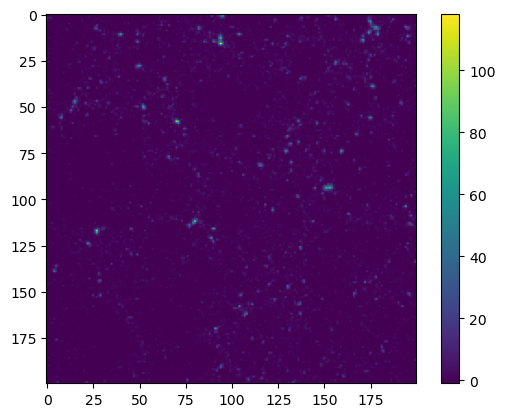

In [221]:
avg=0.03*6912**3/(2000**3)
overdense=val/smallboxvol
otherav=len(x)/(500**3)
trueover=(overdense-otherav)/otherav

plt.imshow(trueover)
plt.colorbar()